In [54]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pulp
tqdm.pandas()

# Code

In [55]:
def solve1(input_df, output_df, dmu_index, super_efficiency=False):

    if len(input_df.index) != len(output_df.index):
        raise ValueError("Number of inputs and outputs must be the same")

    v = pulp.LpVariable.dicts("v", input_df.columns, lowBound=0, cat='Continuous')
    u = pulp.LpVariable.dicts("u",  output_df.columns, lowBound=0, cat='Continuous')

    prob = pulp.LpProblem("DMU", pulp.LpMaximize)

    prob += pulp.lpSum(
        [output_df.loc[dmu_index, output] * u[output] for output in output_df.columns]
        )

    prob += pulp.lpSum(
        [input_df.loc[dmu_index, input_] * v[input_] for input_ in input_df.columns]
        ) == 1

    if super_efficiency == False:
        for dmu in input_df.index:
            prob += pulp.lpSum(
                [input_df.loc[dmu, input_] * v[input_] for input_ in input_df.columns]
                ) >= pulp.lpSum(
                [output_df.loc[dmu, output_] * u[output_] for output_ in output_df.columns]
                )
            
    elif super_efficiency == True:
        for dmu in input_df.index:
            if dmu == dmu_index:
                continue
            prob += pulp.lpSum(
                [input_df.loc[dmu, input_] * v[input_] for input_ in input_df.columns]
                ) >= pulp.lpSum(
                [output_df.loc[dmu, output_] * u[output_] for output_ in output_df.columns]
                )
        
    for input_ in input_df.columns:
        prob += v[input_] >= 0

    for output_ in output_df.columns:
        prob += u[output_] >= 0

    prob.solve()
    return prob, v, u

In [56]:
def analyse1(dmu_index, input_df, output_df, super_efficiency=False):
    prob, v, u = solve1(input_df, output_df, dmu_index, super_efficiency)
    efficiency = pulp.value(prob.objective)
    return efficiency

In [57]:
def compute_efficiency1(dmu_index, input_df, output_df, u_values, v_values):
    u_weights = np.array(u_values)
    v_weights = np.array(v_values)
    y = np.sum(output_df.loc[dmu_index] * u_weights)
    x = np.sum(input_df.loc[dmu_index] * v_weights)
    return y/x

In [58]:
def calculate_weights1(dmu_index, input_df, output_df, dmu_eff):

    if len(input_df.index) != len(output_df.index):
        raise ValueError("Number of inputs and outputs must be the same")

    v = pulp.LpVariable.dicts("v", input_df.columns, lowBound=0, cat='Continuous')
    u = pulp.LpVariable.dicts("u",  output_df.columns, lowBound=0, cat='Continuous')

    prob = pulp.LpProblem("DMU", pulp.LpMinimize)

    composite_input = input_df.drop(dmu_index).sum()
    composite_output = output_df.drop(dmu_index).sum()

    prob += pulp.lpSum(
        [composite_output[output] * u[output] for output in output_df.columns]
        )
    
    prob += pulp.lpSum(
        [composite_input[input_] * v[input_] for input_ in input_df.columns]
        ) == 1
    
    for dmu in input_df.index:
        if dmu == dmu_index:
            continue
        prob += pulp.lpSum(
            [input_df.loc[dmu, input_] * v[input_] for input_ in input_df.columns]
            ) >= pulp.lpSum(
            [output_df.loc[dmu, output_] * u[output_] for output_ in output_df.columns]
            )
        
    prob += pulp.lpSum(
        [output_df.loc[dmu_index, output] * u[output] for output in output_df.columns]
        ) == pulp.lpSum(
        [input_df.loc[dmu_index, input_] * v[input_] * dmu_eff for input_ in input_df.columns]
        )
    
    prob.solve()
    v = [v[var].varValue for var in v]
    u = [u[var].varValue for var in u]
    
    return v, u

In [59]:
def solve2(input_df, output_df, dmu_index):

    if len(input_df.index) != len(output_df.index):
        raise ValueError("Number of inputs and outputs must be the same")

    lambdas = pulp.LpVariable.dicts("lambda", input_df.index, lowBound=0, cat='Continuous')
    theta = pulp.LpVariable("theta", lowBound=0, cat='Continuous')

    prob = pulp.LpProblem("DMU", pulp.LpMinimize)
    prob += theta
    
    for column in output_df.columns:
        prob += pulp.lpSum(
            [output_df.loc[dmu, column] * lambdas[dmu] for dmu in output_df.index]
            ) >= output_df.loc[dmu_index, column]
        
    for column in input_df.columns:
        prob += pulp.lpSum(
            [input_df.loc[dmu, column] * lambdas[dmu] for dmu in input_df.index]
            ) <= input_df.loc[dmu_index, column] * theta
        
    prob += theta >= 0
    
    for dmu in input_df.index:
        prob += lambdas[dmu] >= 0
        
    prob.solve()
    return prob, lambdas, theta

In [60]:
def analyse2(dmu_index, input_df, output_df):
    prob, lambdas, theta = solve2(input_df, output_df, dmu_index)
    if theta.varValue >= 1.0:
        print(f"{dmu_index} is efficient ({theta.varValue})")
    else:
        print(f"{dmu_index} is not efficient")
        dmu_to_aim = []
        for lambda_ in lambdas:
            if lambdas[lambda_].varValue > 0:
                dmu_to_aim.append((lambda_, lambdas[lambda_].varValue))
        print(f"{dmu_index} should aim to be like:")
        for dmu, value in dmu_to_aim:
            print(f"\t{dmu} ({value:.2f})")
        to_reduce_input = []
        for input_ in input_df.columns:
            to_reduce_input.append((input_, input_df.loc[dmu_index, input_]))
        print(f"{dmu_index} should reduce:")
        for input_, value in to_reduce_input:
            print(f"\tInput {input_} by ({value * (1 - theta.varValue):.2f})")
        print("-" * 20)
    return theta.varValue

# Test solve2

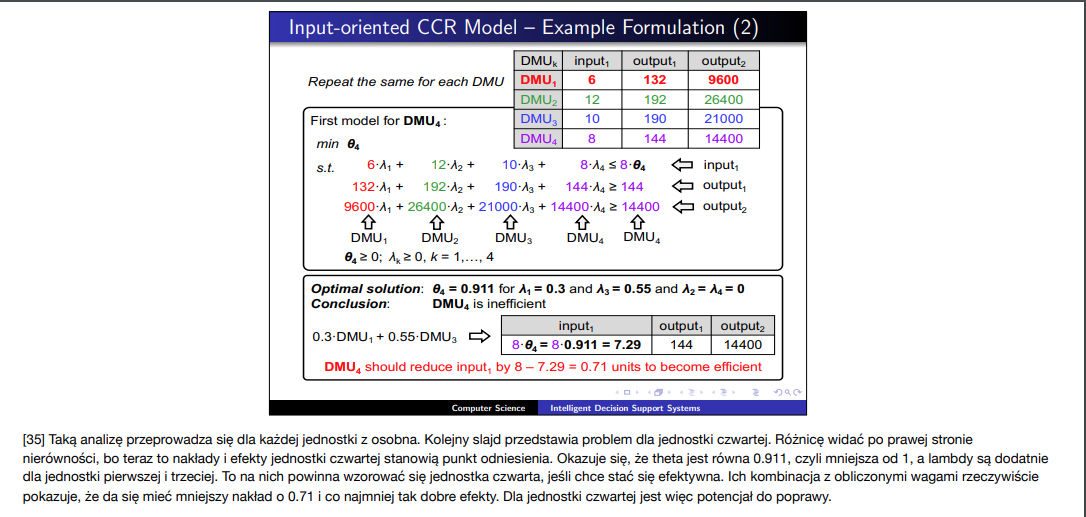

In [61]:
sample_input_df = [[6], [12], [10], [8]]
sample_output_df = [[132, 9600], [192, 26400], [190, 21000], [144, 14400]]

sample_input_df = pd.DataFrame(sample_input_df, columns=['1'], index=['DMU1', 'DMU2', 'DMU3', 'DMU4'])
sample_output_df = pd.DataFrame(sample_output_df, columns=['1', '2'], index=['DMU1', 'DMU2', 'DMU3', 'DMU4'])

In [62]:
results_df = pd.DataFrame()
results_df["eff"] = sample_input_df.progress_apply(lambda x: analyse2(x.name, sample_input_df, sample_output_df), axis=1)
results_df

100%|██████████| 4/4 [00:00<00:00, 76.92it/s]

DMU1 is efficient (1.0)
DMU2 is efficient (1.0)
DMU3 is efficient (1.0)
DMU4 is not efficient
DMU4 should aim to be like:
	DMU1 (0.30)
	DMU3 (0.55)
DMU4 should reduce:
	Input 1 by (0.71)
--------------------


,eff
DMU1,1.000000
DMU2,1.000000
DMU3,1.000000
DMU4,0.911392


# Test solve1

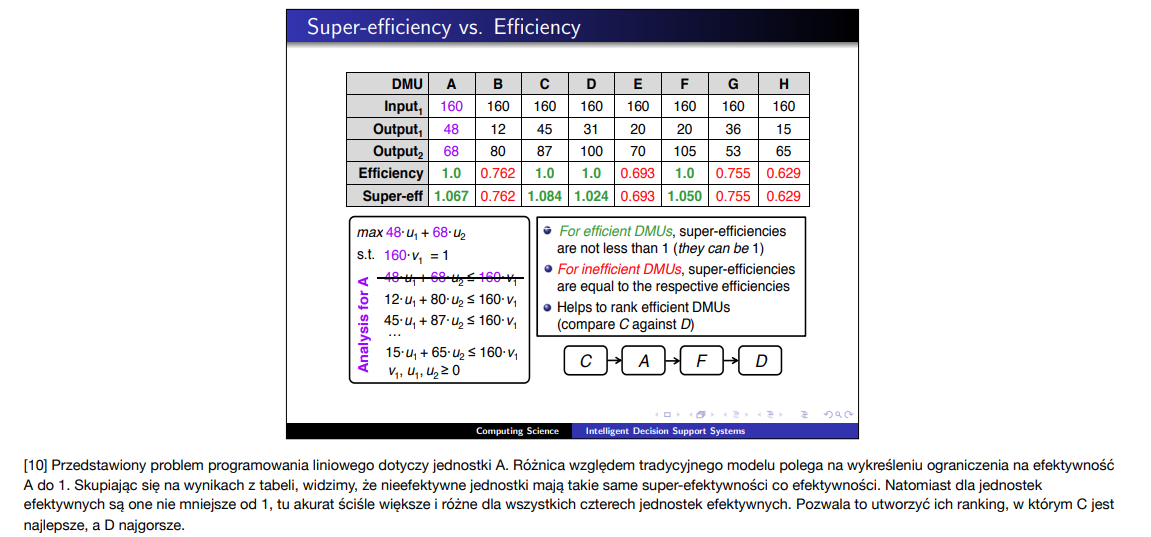

In [63]:
data = {
    "DMU": ["A", "B", "C", "D", "E", "F", "G", "H"],
    "i1": [160, 160, 160, 160, 160, 160, 160, 160],
    "o1": [48, 12, 45, 31, 20, 20, 36, 15],
    "o2": [68, 80, 87, 100, 70, 105, 53, 65]
}

df = pd.DataFrame(data)
df.set_index('DMU', inplace=True)

input_df = df[['i1']]
output_df = df[['o1', 'o2']]

In [64]:
output_df

,o1,o2
DMU,,
A,48,68
B,12,80
C,45,87
D,31,100
E,20,70
F,20,105
G,36,53
H,15,65


In [65]:
results_df = pd.DataFrame()

results_df["eff"] = input_df.progress_apply(lambda x: analyse1(x.name, input_df, output_df), axis=1)
results_df["super_eff"] = input_df.progress_apply(lambda x: analyse1(x.name, input_df, output_df, super_efficiency=True), axis=1)

results_df = results_df.round(3)
results_df.T

100%|██████████| 8/8 [00:00<00:00, 100.00it/s]


DMU,A,B,C,D,E,F,G,H
eff,1.000,0.762,1.000,1.000,0.693,1.00,0.755,0.629
super_eff,1.067,0.762,1.084,1.024,0.693,1.05,0.755,0.629


In [66]:
def compute_cross_eff_matrix(input_df, output_df):

    efficiency = pd.DataFrame()
    cross_efficiency = pd.DataFrame()
    
    efficiency['efficiency'] = input_df.progress_apply(lambda dmu: analyse1(dmu.name, input_df, output_df), axis=1)
    efficiency["v_values"] = input_df.progress_apply(lambda dmu: calculate_weights1(dmu.name, input_df, output_df, efficiency.loc[dmu.name, 'efficiency'])[0], axis=1)
    efficiency["u_values"] = input_df.progress_apply(lambda dmu: calculate_weights1(dmu.name, input_df, output_df, efficiency.loc[dmu.name, 'efficiency'])[1], axis=1)


    for dmu_aim in input_df.index:
        for dmu_weights in efficiency.index:           
            cross_efficiency.loc[dmu_weights, dmu_aim] = compute_efficiency1(
                dmu_index=dmu_aim,
                input_df=input_df,
                output_df=output_df,
                u_values=efficiency.loc[dmu_weights, 'u_values'],
                v_values=efficiency.loc[dmu_weights, 'v_values']
            )

    cross_efficiency.loc['Average'] = cross_efficiency.mean()

    return cross_efficiency

In [67]:
cross_efficiency = compute_cross_eff_matrix(input_df, output_df)
cross_efficiency

100%|██████████| 8/8 [00:00<00:00, 106.89it/s]


,A,B,C,D,E,F,G,H
A,1.000000,0.250000,0.937500,0.645833,0.416667,0.416667,0.750000,0.312500
B,0.647619,0.761905,0.828571,0.952381,0.666667,1.000000,0.504762,0.619048
C,1.000000,0.419355,1.000000,0.796595,0.528674,0.622760,0.755376,0.430108
D,0.787251,0.749004,0.941833,1.000000,0.693227,1.000000,0.607968,0.629482
E,0.787251,0.749004,0.941833,1.000000,0.693227,1.000000,0.607968,0.629482
F,0.647619,0.761905,0.828571,0.952381,0.666667,1.000000,0.504762,0.619048
G,1.000000,0.419355,1.000000,0.796595,0.528674,0.622760,0.755376,0.430108
H,0.787251,0.749004,0.941833,1.000000,0.693227,1.000000,0.607968,0.629482
Average,0.832124,0.607441,0.927518,0.892973,0.610879,0.832773,0.636773,0.537407


# Homework 1

Przy użyciu biblioteki PULP napisz skrypt w pythonie, który dla każdej jednostki wyznaczy jej miarę efektywności. Dodatkowo dla każdej z jednostek nieefektywnych znajdź hipotetyczną jednostkę porównawczą oraz poprawki potrzebne do osiągnięcia efektywności. Użyj modelu CCR granicznej analizy danych zorientowanego na *nakłady*. Skrypt powinien wczytywać dane z plików CSV tak, aby po zmianie danego pliku na inny (o takiej samej strukturze) obliczał on efektywność dla nowych danych.

In [68]:
input_df = pd.read_csv('inputs.csv', sep=";", index_col=0)
input_df

,i1,i2,i3,i4
WAW,10.5,36,129.4,7.0
KRK,3.1,19,31.6,7.9
KAT,3.6,32,57.4,10.5
WRO,1.5,12,18.0,3.0
POZ,1.5,10,24.0,4.0
LCJ,0.6,12,24.0,3.9
GDN,1.0,15,42.9,2.5
SZZ,0.7,10,25.7,1.9
BZG,0.3,6,3.4,1.2
RZE,0.6,6,11.3,2.7


In [69]:
output_df = pd.read_csv('outputs.csv', sep=";", index_col=0)
output_df

,o1,o2
WAW,9.500,129.70
KRK,2.900,31.30
KAT,2.400,21.10
WRO,1.500,18.80
POZ,1.300,16.20
LCJ,0.300,4.20
GDN,2.000,23.60
SZZ,0.300,4.20
BZG,0.300,6.20
RZE,0.300,3.50


In [70]:
results_df = pd.DataFrame()

results_df["eff"] = input_df.progress_apply(lambda x: analyse2(x.name, input_df, output_df), axis=1)
results_df

100%|██████████| 11/11 [00:00<00:00, 83.33it/s]

WAW is efficient (1.0)
KRK is efficient (1.0)
KAT is not efficient
KAT should aim to be like:
	KRK (0.00)
	WRO (1.23)
	GDN (0.27)
KAT should reduce:
	Input i1 by (1.47)
	Input i2 by (13.08)
	Input i3 by (23.46)
	Input i4 by (4.29)
--------------------
WRO is efficient (1.0)
POZ is not efficient
POZ should aim to be like:
	WAW (0.05)
	KRK (0.07)
	WRO (0.20)
	GDN (0.16)
POZ should reduce:
	Input i1 by (0.30)
	Input i2 by (2.00)
	Input i3 by (4.80)
	Input i4 by (0.80)
--------------------
LCJ is not efficient
LCJ should aim to be like:
	GDN (0.16)
	BZG (0.06)
LCJ should reduce:
	Input i1 by (0.42)
	Input i2 by (8.40)
	Input i3 by (16.80)
	Input i4 by (2.73)
--------------------
GDN is efficient (1.0)
SZZ is not efficient
SZZ should aim to be like:
	WAW (0.00)
	GDN (0.15)
	BZG (0.06)
SZZ should reduce:
	Input i1 by (0.51)
	Input i2 by (7.29)
	Input i3 by (18.74)
	Input i4 by (1.39)
--------------------
BZG is efficient (1.0)
RZE is not efficient
RZE should aim to be like:
	WRO (0.12)
	GDN 

,eff
WAW,1.000000
KRK,1.000000
KAT,0.591209
WRO,1.000000
POZ,0.799801
LCJ,0.300036
GDN,1.000000
SZZ,0.270787
BZG,1.000000
RZE,0.409183


In [71]:
cross_efficiency = compute_cross_eff_matrix(input_df, output_df)
cross_efficiency

100%|██████████| 11/11 [00:00<00:00, 92.44it/s] 


,WAW,KRK,KAT,WRO,POZ,LCJ,GDN,SZZ,BZG,RZE,IEG
WAW,1.000000,0.213833,0.108455,0.338216,0.218581,0.058122,0.509483,0.119304,0.278849,0.069962,0.010974
KRK,0.799979,1.000000,0.455605,0.908046,0.590230,0.136207,0.507998,0.127197,0.961460,0.289289,0.000859
KAT,0.912766,1.000003,0.591209,1.000000,0.773693,0.259122,1.000000,0.237744,0.972025,0.408825,0.002389
WRO,0.996612,1.000000,0.470344,1.000000,0.649394,0.153444,0.615222,0.156005,1.000000,0.295430,0.002574
POZ,1.000000,1.000000,0.562943,1.000000,0.799801,0.254844,1.000000,0.243064,0.909116,0.403187,0.006229
LCJ,0.595046,0.491070,0.277842,0.604639,0.511841,0.300036,1.000000,0.260584,1.000000,0.273050,0.077679
GDN,0.452381,0.467742,0.333333,0.500000,0.433333,0.250000,1.000000,0.214286,0.500000,0.250000,0.025000
SZZ,1.000000,0.755486,0.371452,0.856267,0.737176,0.272842,1.000000,0.270787,1.000000,0.346177,0.035881
BZG,0.549658,0.543181,0.201585,0.572760,0.370161,0.095968,0.301677,0.089620,1.000000,0.169854,0.005276
RZE,0.902747,0.996316,0.591203,1.000000,0.770046,0.260934,1.000000,0.237958,1.000000,0.409183,0.002376


# Homework 2

Uzupełnij skrypt zadania z poprzednich zajęć tak, aby dla wyznaczana była również superefektywność analizowanych lotnisk oraz średnia efektywność krzyżowa. Przy pomocy podanego pliku samples.csv zawierającego 100 próbek wag wejść i wyjść wyznacz również rozkład efektywności dla każdej z jednostek
(przy podziale na 5 równych przedziałów) oraz oszacuj oczekiwaną wartość efektywności jednostek. Na podstawie superefektywności, średniej efektywności krzyżowej oraz wartości oczekiwanej wyznacz rankingi jednostek. Określ czy rankingi uzyskane tymi trzema miarami są zgodne i spróbuj odpowiedzieć na
pytanie dlaczego są lub nie są zgodne – co wpływa na podobieństwa i/lub różnice w pozycjach rankingowych poszczególnych lotnisk.

In [73]:
input_df

,i1,i2,i3,i4
WAW,10.5,36,129.4,7.0
KRK,3.1,19,31.6,7.9
KAT,3.6,32,57.4,10.5
WRO,1.5,12,18.0,3.0
POZ,1.5,10,24.0,4.0
LCJ,0.6,12,24.0,3.9
GDN,1.0,15,42.9,2.5
SZZ,0.7,10,25.7,1.9
BZG,0.3,6,3.4,1.2
RZE,0.6,6,11.3,2.7


In [74]:
output_df

,o1,o2
WAW,9.500,129.70
KRK,2.900,31.30
KAT,2.400,21.10
WRO,1.500,18.80
POZ,1.300,16.20
LCJ,0.300,4.20
GDN,2.000,23.60
SZZ,0.300,4.20
BZG,0.300,6.20
RZE,0.300,3.50


In [95]:
results_df = pd.DataFrame()
results_df["eff1"] = input_df.progress_apply(lambda x: analyse1(x.name, input_df, output_df), axis=1)
results_df["super_eff"] = input_df.progress_apply(lambda x: analyse1(x.name, input_df, output_df, super_efficiency=True), axis=1)


100%|██████████| 11/11 [00:00<00:00, 76.39it/s]


In [76]:
results_df["error"].sum().round(3)

-0.0

In [77]:
cross_efficiency = compute_cross_eff_matrix(input_df, output_df)
cross_efficiency

100%|██████████| 11/11 [00:00<00:00, 94.01it/s] 


,WAW,KRK,KAT,WRO,POZ,LCJ,GDN,SZZ,BZG,RZE,IEG
WAW,1.000000,0.213833,0.108455,0.338216,0.218581,0.058122,0.509483,0.119304,0.278849,0.069962,0.010974
KRK,0.799979,1.000000,0.455605,0.908046,0.590230,0.136207,0.507998,0.127197,0.961460,0.289289,0.000859
KAT,0.912766,1.000003,0.591209,1.000000,0.773693,0.259122,1.000000,0.237744,0.972025,0.408825,0.002389
WRO,0.996612,1.000000,0.470344,1.000000,0.649394,0.153444,0.615222,0.156005,1.000000,0.295430,0.002574
POZ,1.000000,1.000000,0.562943,1.000000,0.799801,0.254844,1.000000,0.243064,0.909116,0.403187,0.006229
LCJ,0.595046,0.491070,0.277842,0.604639,0.511841,0.300036,1.000000,0.260584,1.000000,0.273050,0.077679
GDN,0.452381,0.467742,0.333333,0.500000,0.433333,0.250000,1.000000,0.214286,0.500000,0.250000,0.025000
SZZ,1.000000,0.755486,0.371452,0.856267,0.737176,0.272842,1.000000,0.270787,1.000000,0.346177,0.035881
BZG,0.549658,0.543181,0.201585,0.572760,0.370161,0.095968,0.301677,0.089620,1.000000,0.169854,0.005276
RZE,0.902747,0.996316,0.591203,1.000000,0.770046,0.260934,1.000000,0.237958,1.000000,0.409183,0.002376


Oprócz przedziału efektywności, interesujący dla analityka może być też rozkład
miary efektywności (jak często efektywność dla danej jednostki jest blisko jej dolnej
granicy a jak często raczej przy górnej). Aby oszacować taki rozkład można wy-
korzystać symulację Monte Carlo. Polega ona na losowym doborze próbki danych
i oszacowanie poszukiwanej miary na podstawie tej próby.W przypadku DEA losowany jest zestaw n próbek wag (nakładów i efektów).
Dla każdej próbki wyznaczana jest wartość efektywności wszystkich jednostek na
podstawie standardowego wzoru na efektywność. Ze względu na to, że losowe
wagi nie zapewniają efektywności z zakresu [0-1] to wszystkie efektywności są
normalizowane poprzez podzielenie przez maksimum.

1. wylosuj n wektorów wag v i u
2. zastosuj wagi dla każdej jednostki i wyznacz efektywność
3. znormalizuj efektywności

In [91]:
v_columns = input_df.columns.tolist()
u_columns = output_df.columns.tolist()

samples_df = pd.read_csv('samples_homework.csv', sep=";", index_col=0)
samples_df

,i1,i2,i3,i4,o1,o2
sample,,,,,,
1,0.096443,0.059350,0.065224,0.778983,0.620824,0.379176
2,0.032029,0.304959,0.427426,0.235586,0.513536,0.486464
3,0.266256,0.246940,0.217498,0.269306,0.247490,0.752510
4,0.159062,0.635512,0.202159,0.003267,0.223838,0.776162
5,0.096716,0.809025,0.026741,0.067518,0.136140,0.863860
...,...,...,...,...,...,...
96,0.685045,0.072530,0.073261,0.169164,0.339330,0.660670
97,0.298367,0.138924,0.266746,0.295963,0.429870,0.570130
98,0.418018,0.356657,0.113764,0.111562,0.731184,0.268816


In [92]:
efficiencies = pd.DataFrame()

for dmu in input_df.index:
    # calc n times efficiency
    for s in samples_df.index:
        eff = compute_efficiency1(
            dmu_index=dmu,
            input_df=input_df,
            output_df=output_df,
            u_values=samples_df.loc[s, u_columns],
            v_values=samples_df.loc[s, v_columns]
        )
        efficiencies.loc[dmu, s] = eff

efficiencies = efficiencies / efficiencies.max()
efficiencies



,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
WAW,1.000000,1.000000,1.000000,1.000000,1.000000,0.945758,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.968440,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
KRK,0.438657,0.789666,0.697743,0.648502,0.483741,0.787800,0.620871,0.628367,0.650044,0.671675,...,0.743740,0.797171,0.669275,0.755254,0.683547,0.697169,0.763508,0.657161,0.689747,0.542400
KAT,0.207248,0.313097,0.284394,0.256472,0.195855,0.302402,0.266723,0.259238,0.273775,0.289381,...,0.293327,0.339899,0.269474,0.322665,0.295197,0.315417,0.312725,0.281961,0.306363,0.237551
WRO,0.570962,0.822563,0.749395,0.639864,0.469188,0.824539,0.661037,0.658552,0.735199,0.735953,...,0.791144,0.849667,0.727764,0.831357,0.802262,0.799241,0.834559,0.660514,0.656427,0.517831
POZ,0.396793,0.600497,0.569723,0.554081,0.465775,0.587760,0.520351,0.525370,0.540278,0.539643,...,0.583911,0.647386,0.544879,0.574549,0.552136,0.612593,0.595803,0.563503,0.570513,0.485899
LCJ,0.102429,0.148556,0.143724,0.130457,0.103366,0.148029,0.125749,0.125518,0.138746,0.133545,...,0.145887,0.181586,0.134870,0.144444,0.145988,0.179006,0.153830,0.137151,0.132205,0.106940
GDN,0.550061,0.533861,0.545173,0.504061,0.458444,0.506280,0.530281,0.509750,0.554637,0.545682,...,0.530158,0.633841,0.519720,0.559337,0.580588,0.701572,0.563285,0.559243,0.557272,0.492514
SZZ,0.144184,0.152153,0.154164,0.140720,0.122925,0.147255,0.143863,0.140763,0.155533,0.149609,...,0.152117,0.179480,0.147406,0.155091,0.162840,0.194251,0.160424,0.150901,0.144927,0.126678
BZG,0.509252,0.890585,0.753821,0.529001,0.320960,1.000000,0.557479,0.565212,0.752048,0.698159,...,0.851030,1.000000,0.725601,0.909152,0.926899,0.884345,0.960985,0.529932,0.463264,0.329093
RZE,0.143895,0.254940,0.234178,0.221521,0.170711,0.254443,0.205465,0.207520,0.217445,0.218112,...,0.243642,0.290276,0.219611,0.240624,0.226151,0.260818,0.252308,0.228342,0.233397,0.184045


In [94]:
bins = np.linspace(0, 1, 6)
bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]

counts = pd.DataFrame(index=efficiencies.index, columns=bin_labels)

for dmu in efficiencies.index:
    bin_counts = pd.cut(efficiencies.loc[dmu], bins=bins, labels=bin_labels, include_lowest=True).value_counts().sort_index()
    for label in bin_labels:
        counts.loc[dmu, label] = bin_counts.get(label, 0) / len(efficiencies.columns)



# dodaj wartość oczekiwaną
counts['expected'] = efficiencies.mean(axis=1)
counts

,0.0-0.2,0.2-0.4,0.4-0.6,0.6-0.8,0.8-1.0,expected
WAW,0.0,0.0,0.0,0.12,0.88,0.947652
KRK,0.0,0.01,0.24,0.66,0.09,0.669281
KAT,0.04,0.94,0.02,0.0,0.0,0.284057
WRO,0.0,0.0,0.14,0.67,0.19,0.709858
POZ,0.0,0.02,0.79,0.19,0.0,0.537948
LCJ,0.99,0.01,0.0,0.0,0.0,0.135914
GDN,0.0,0.07,0.8,0.11,0.02,0.537152
SZZ,0.96,0.04,0.0,0.0,0.0,0.147274
BZG,0.0,0.08,0.3,0.18,0.44,0.732719
RZE,0.24,0.76,0.0,0.0,0.0,0.223976


In [96]:
final_results = pd.DataFrame(index=counts.index)
final_results['expected'] = counts['expected']
final_results['cross'] = cross_efficiency.loc['Average']
final_results['super'] = results_df['super_eff']

final_results

,expected,cross,super
WAW,0.947652,0.793872,2.277949
KRK,0.669281,0.717769,1.123783
KAT,0.284057,0.382939,0.591209
WRO,0.709858,0.755546,1.039946
POZ,0.537948,0.573808,0.799801
LCJ,0.135914,0.212557,0.300036
GDN,0.537152,0.812216,2.000000
SZZ,0.147274,0.200981,0.270787
BZG,0.732719,0.863378,1.745932
RZE,0.223976,0.287467,0.409183


In [114]:
# create 3 rankings
final_results['expected_rank'] = final_results['expected'].rank(ascending=False)

final_results['cross_rank'] = final_results['cross'].rank(ascending=False)

final_results['super_rank'] = final_results['super'].rank(ascending=False)

final_results.round(3)

,expected,cross,super,expected_rank,cross_rank,super_rank
WAW,0.948,0.794,2.278,1.0,3.0,1.0
KRK,0.669,0.718,1.124,4.0,5.0,4.0
KAT,0.284,0.383,0.591,7.0,7.0,7.0
WRO,0.710,0.756,1.040,3.0,4.0,5.0
POZ,0.538,0.574,0.800,5.0,6.0,6.0
LCJ,0.136,0.213,0.300,10.0,9.0,9.0
GDN,0.537,0.812,2.000,6.0,2.0,2.0
SZZ,0.147,0.201,0.271,9.0,10.0,10.0
BZG,0.733,0.863,1.746,2.0,1.0,3.0
RZE,0.224,0.287,0.409,8.0,8.0,8.0


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

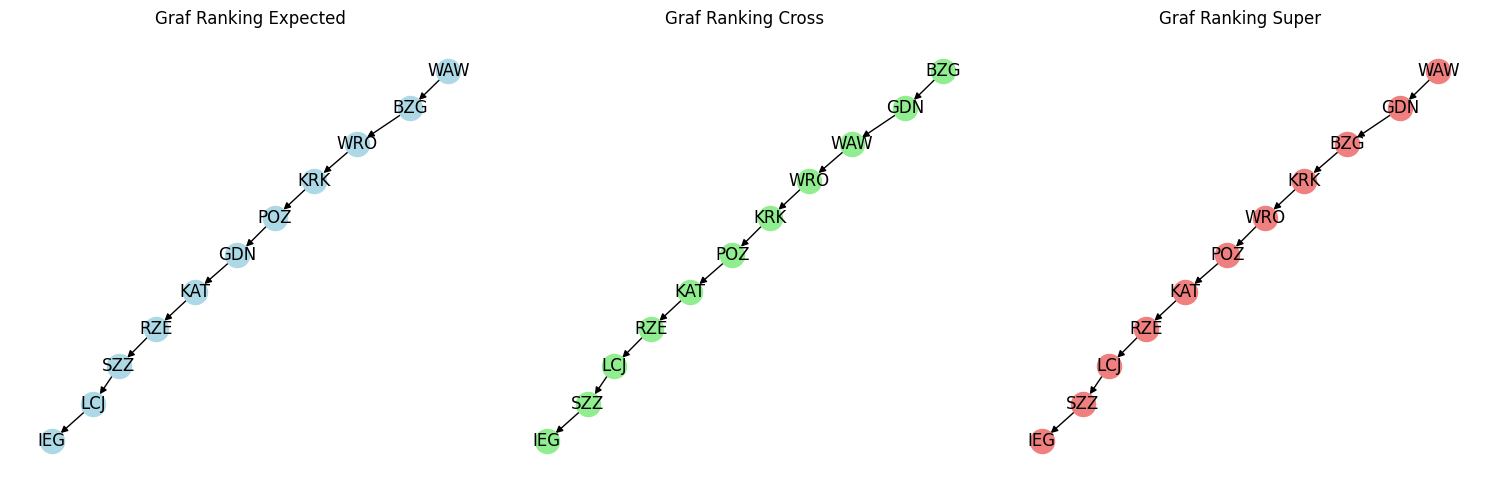

In [113]:
def create_graph(ranking):
    G = nx.DiGraph()
    sorted_units = ranking.sort_values().index
    for i in range(len(sorted_units) - 1):
        G.add_edge(sorted_units[i], sorted_units[i + 1])
    return G

# Tworzenie grafów dla każdego rankingu
G_expected = create_graph(final_results['expected_rank'])
G_cross = create_graph(final_results['cross_rank'])
G_super = create_graph(final_results['super_rank'])

# Rysowanie grafów
plt.figure(figsize=(15, 5))

# Graf Expected
plt.subplot(1, 3, 1)
pos = nx.kamada_kawai_layout(G_expected)
nx.draw(G_expected, pos, with_labels=True, node_color='lightblue', arrows=True)
plt.title('Graf Ranking Expected')

# Graf Cross
plt.subplot(1, 3, 2)
pos = nx.kamada_kawai_layout(G_cross)
nx.draw(G_cross, pos, with_labels=True, node_color='lightgreen', arrows=True)
plt.title('Graf Ranking Cross')

# Graf Super
plt.subplot(1, 3, 3)
pos = nx.kamada_kawai_layout(G_super)
nx.draw(G_super, pos, with_labels=True, node_color='lightcoral', arrows=True)
plt.title('Graf Ranking Super')

plt.tight_layout()
plt.show()